In [1]:
# Data managing
import torch
import torch.nn as nn

# Image management
from IPython.display import Image

### Setup device

It's either CPU or single GPU

In [2]:
use_gpu = True
device = "cuda" if use_gpu and torch.cuda.is_available() else "cpu"

print("Working device : ", end='')
if device == "cuda":
    print("GPU - {}".format(torch.cuda.get_device_name(0)))
    !nvidia-smi
else:
    print("CPU")

Working device : GPU - GeForce RTX 3060 Ti
Sat Dec 26 14:01:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 306...  Off  | 00000000:08:00.0  On |                  N/A |
| 47%   52C    P5    33W / 200W |    328MiB /  7981MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                             

In this notebook, results from [Deep Pictorial Gaze Estimation](https://arxiv.org/pdf/1807.10002.pdf) [1] will be replicated, but we won't use *gazemaps* as intermediate supervision.

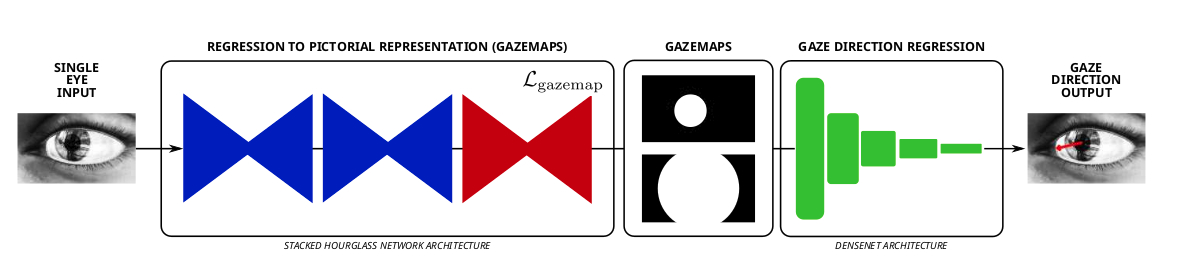

In [3]:
Image('GazeEstimation_architecture.jpg')

Visual understanding of neural network architecture, reference from [1]

### Dense Net

As states in the [Densely Connected Convolutional Networks](https://arxiv.org/pdf/1608.06993.pdf) [2], DenseNet outperformed SOTA Neural Networks (by the time of 2017) in Image Classification Task, while using less parameters than, for example, [ResNet](https://arxiv.org/pdf/1512.03385.pdf) [3].

This can be useful for our task, because we got a fact, that our network have to be light-weight and fast.

We will use this architecture as a regressor from features that we'll get from Hourglass Network

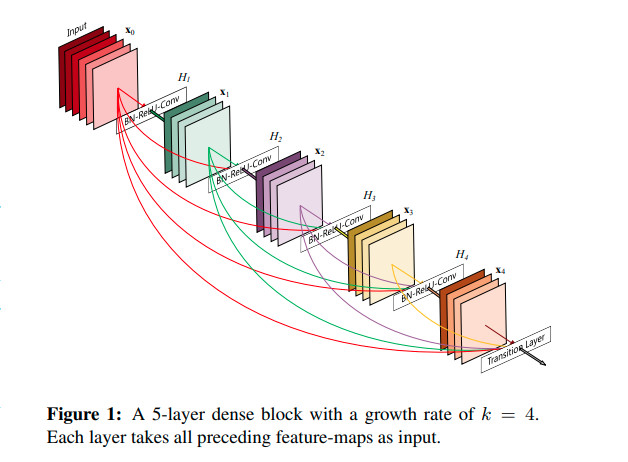

In [4]:
Image('DenseNet_architecture.jpg')

DenseNet architecture, refernce from [2]

In [5]:
class Composite(nn.Module):
    def __init__(self, in_channels=3, out_channels=8, kernel_size=[3, 3], padding=[1, 1]):
        super(Composite, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                              kernel_size=kernel_size, padding=padding)
    def forward(self, x):
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv(x)
        return x

In [6]:
class DenseBlock(nn.Module):
    def __init__(self, number_of_layers=4, in_channels=32, growth_rate=8):
        super(DenseBlock, self).__init__()
        self.number_of_layers = number_of_layers
        self.composites = nn.Sequential()
        for i in range(number_of_layers):
            self.composites.add_module(
                "composite_{}".format(i),
                Composite(in_channels + growth_rate * i, growth_rate)
            )
    def forward(self, x):
        for i in range(len(self.composites)):
            x_prev = x
            x = self.composites[i](x)
            x = torch.cat([x, x_prev], dim=1)
        return x

In [7]:
class DenseNet(nn.Module):
    def __init__(self, growth_rate=8, 
                 compression_factor=0.5, 
                 num_layers_per_block=(4, 4, 4, 4), 
                 dense_net_input_features=64):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.compression_factor = compression_factor
        self.num_layers_per_block = num_layers_per_block
        self.number_of_dense_blocks = len(num_layers_per_block)
        
        self.pre_conv = nn.Conv2d(in_channels=dense_net_input_features, \
                                  out_channels=2 * self.growth_rate, kernel_size=[1, 1])
        
        self.dense_blocks = nn.Sequential()
        self.transition_layers = nn.Sequential()
        
        initial_feature_maps = 2 * self.growth_rate
        dense_block_out = None  
        transition_out = None
        for i in range(self.number_of_dense_blocks):
            real_input = initial_feature_maps if transition_out is None else transition_out
            self.dense_blocks.add_module(
                "dense_block_{}".format(i),
                DenseBlock(self.num_layers_per_block[i], in_channels=real_input, growth_rate=self.growth_rate)
            )
            # Since we did torch.cat "self.num_l_p_b[i]" time, it growed like that
            dense_block_out = self.num_layers_per_block[i] * self.growth_rate + real_input
            
            # Use kind of combination of both transition and bottleneck layers
            transition_out = int(self.compression_factor * min(4 * self.growth_rate, dense_block_out))
            if i + 1 != self.number_of_dense_blocks:
                self.transition_layers.add_module(
                    "transition_layer_{}".format(i),
                    nn.Sequential(
                        Composite(dense_block_out, transition_out, kernel_size=[1, 1], padding=[0, 0]),
                        nn.AvgPool2d(kernel_size=[2, 2], stride=2)
                    )
                ) 
        self.flatten = nn.Flatten()
        self.regressor = nn.Linear(dense_block_out, 2)
        
    def forward(self, x):
        x = self.pre_conv(x)
        # x.shape = (N, 2 * self.growth_rate, H, W)
        for i in range(self.number_of_dense_blocks):
            x = self.dense_blocks[i](x)
            if i + 1 != self.number_of_dense_blocks:
                x = self.transition_layers[i](x)
        x = torch.mean(x, dim = (2, 3))
        x = self.flatten(x)
        return self.regressor(x)

In [8]:
dummy_tensor = torch.rand(1, 3, 224, 224).to(device)

### DenseNet testing

In [ ]:
model = DenseNet(growth_rate=8, compression_factor=0.5, num_layers_per_block=[4, 4, 4, 4], dense_net_input_features=3).to(device)

In [ ]:
%%timeit
model(dummy_tensor)

In [ ]:
torch.cuda.empty_cache()

### Spa-Net, aka Spatial Net

This architecture proposed in [1] to predict gaze direction.

As mentioned above, intermediate supervision won't be used for the purpose of simplicity of architecture, but still it can be implemented later.

In [9]:
from src.Hourglass import Hourglass, init_weights

In [10]:
class SpaNet(nn.Module):
    def __init__(self, in_features=64, middle_features=32, residual_count=3, use_batchnorm=True):
        super(SpaNet, self).__init__()
        # (N, 3, 80, 120)
        self.pre_conv = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Conv2d(in_channels=3, out_channels=in_features, kernel_size=[3, 3], padding=[1, 1])
        )
        # (N, 64, 80, 120)
        self.hourglass1= Hourglass(in_features=in_features, middle_features=middle_features, \
                                   residual_count=residual_count, use_batchnorm=use_batchnorm)
        self.hourglass2= Hourglass(in_features=in_features, middle_features=middle_features, \
                                   residual_count=residual_count, use_batchnorm=use_batchnorm)
        self.hourglass3= Hourglass(in_features=in_features, middle_features=middle_features, \
                                   residual_count=residual_count, use_batchnorm=use_batchnorm)
        self.dense_net = DenseNet(growth_rate=8, \
                                  compression_factor=0.5, \
                                  num_layers_per_block=(4, 4, 4, 4), \
                                  dense_net_input_features=in_features)
    def forward(self, x):
        x = self.pre_conv(x)
        x = self.hourglass1(x)
        x = self.hourglass2(x)
        x = self.hourglass3(x)
        return self.dense_net(x)

In [11]:
model = SpaNet().to(device)
init_weights(model)

In [12]:
model.eval()

SpaNet(
  (pre_conv): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU()
    (2): Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
  )
  (hourglass1): Hourglass(
    (down_sample): Sequential(
      (0): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
      (1): Residual(
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Sequential(
          (0): Conv2d(64, 32, kernel_size=[1, 1], stride=(1, 1))
          (1): ReLU()
        )
        (conv2): Sequential(
          (0): Conv2d(32, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (1): ReLU()
        )
        (conv3): Sequential(
          (0): Conv2d(32, 6

In [13]:
with torch.no_grad():
    model(dummy_tensor).shape

In [14]:
%%timeit
with torch.no_grad():
    model(dummy_tensor)

15.7 ms ± 196 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
class SpaNet_2(nn.Module):
    def __init__(self):
        super(SpaNet_2).__init__()
        # (N, 3, 80, 120)
        self.pre_conv = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Conv2d(in_channels=3, out_channels=in_features, kernel_size=[3, 3], padding=[1, 1])
        )
        # (N, 64, 80, 120)
        self.hourglass1= Hourglass(in_features=in_features, middle_features=middle_features, \
                                   residual_count=residual_count, use_batchnorm=use_batchnorm)
        self.hourglass2= Hourglass(in_features=in_features, middle_features=middle_features, \
                                   residual_count=residual_count, use_batchnorm=use_batchnorm)
        self.hourglass3= Hourglass(in_features=in_features, middle_features=middle_features, \
                                   residual_count=residual_count, use_batchnorm=use_batchnorm)
        self.dense_net = torch_dense_net
    def forward(self, x):
        x = self.pre_conv(x)
        x = self.hourglass1(x)
        x = self.hourglass2(x)
        x = self.hourglass3(x)
        return self.dense_net(x)